In [1]:
# 1.0 Read in data ----
#       LeCam and Neyman Precipitation Data from J.A.Rice 3e Datasets
#      rainfall of summer storms, in inches, measured by network of rain gauges
#     southern Illinois for the years 1960-1964
#     measurements are average amount of rainfall from each storm
#

# setwd("C:/Users/liboa/OneDrive/stat/R_codes/")
file0.60<-"./JARice_data/ASCII Comma/Chapter 10/illinois60.txt"
file0.60data<-scan(file=file0.60,sep=",")
file0.61<-"./JARice_data/ASCII Comma/Chapter 10/illinois61.txt"
file0.61data<-scan(file=file0.61,sep=",")
file0.62<-"./JARice_data/ASCII Comma/Chapter 10/illinois62.txt"
file0.62data<-scan(file=file0.62,sep=",")
file0.63<-"./JARice_data/ASCII Comma/Chapter 10/illinois63.txt"
file0.63data<-scan(file=file0.63,sep=",")
file0.64<-"./JARice_data/ASCII Comma/Chapter 10/illinois64.txt"
file0.64data<-scan(file=file0.64,sep=",")
data.precipitation<-c(file0.60data, file0.61data, file0.62data, file0.63data, file0.64data)

In [2]:
# Convert inches to mm
data.precipitation <- data.precipitation*25.4

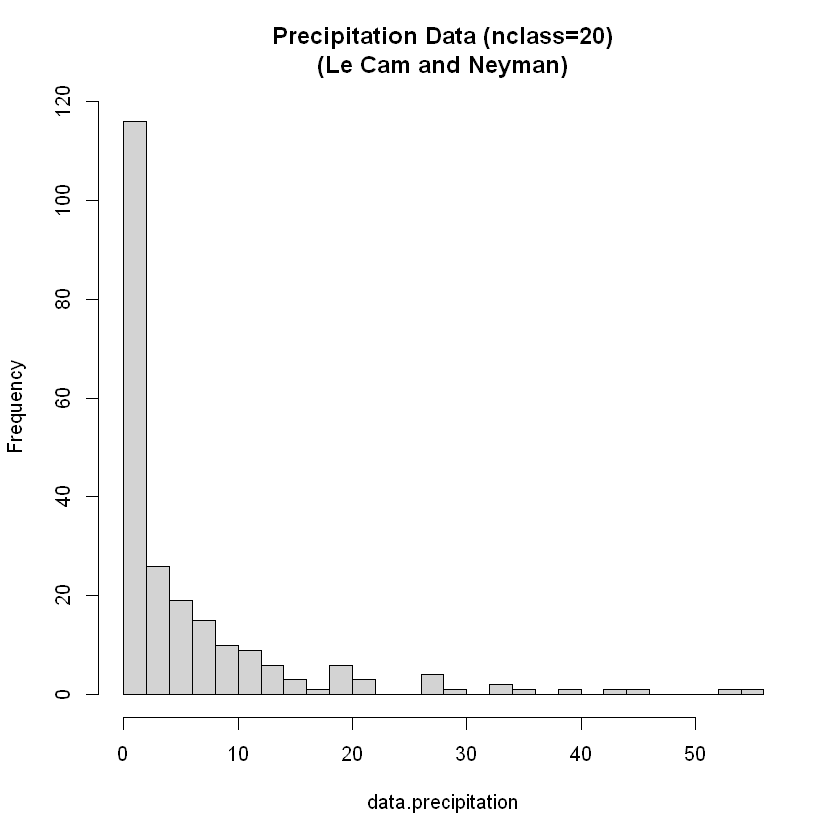

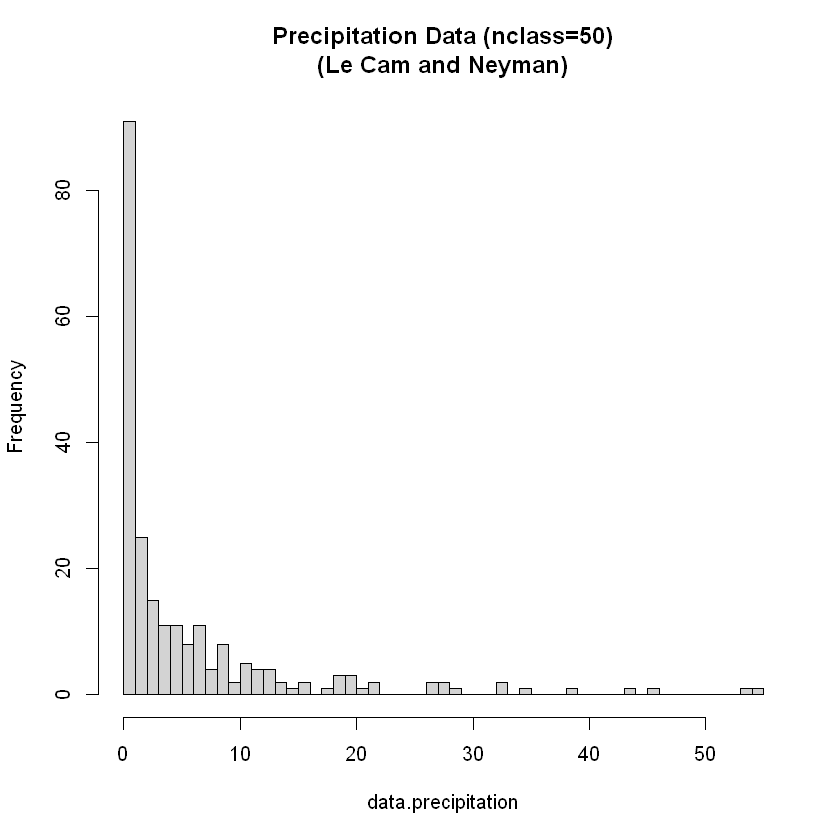

In [3]:
# 2.  Display the data ----
#   2.1.1 Histograms with different bin-counts (nclass) ----
par(mfcol=c(1,1))
hist(data.precipitation,nclass=20,
     main="Precipitation Data (nclass=20)\n(Le Cam and Neyman)")

hist(data.precipitation,nclass=50,
     main="Precipitation Data (nclass=50)\n(Le Cam and Neyman)")

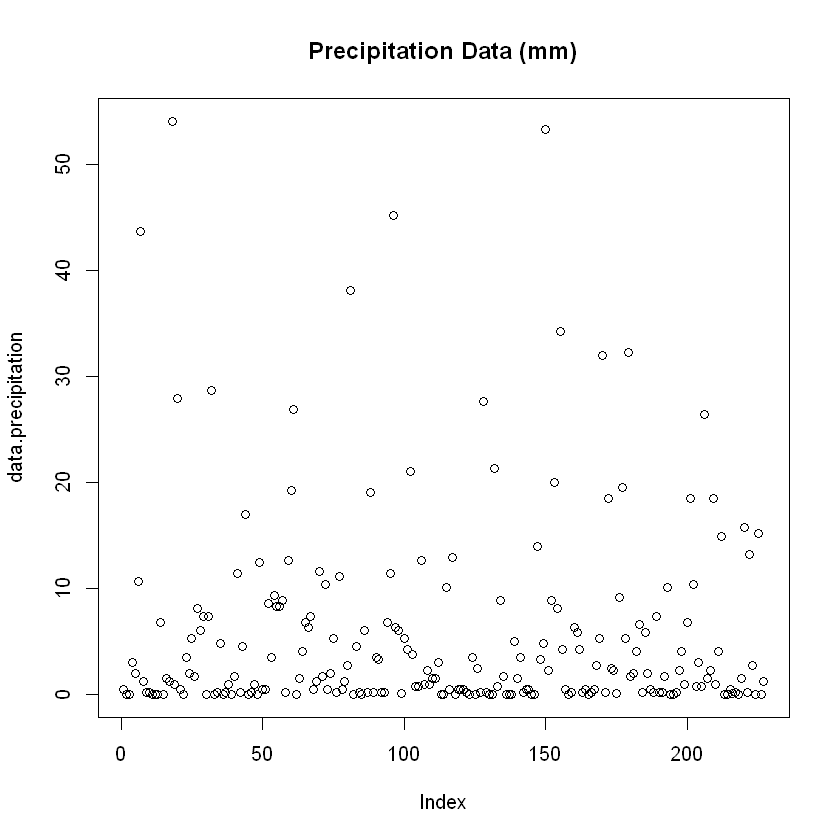

In [72]:
#   2.2 Index plot ----
plot(data.precipitation, main="Precipitation Data (mm)")

In [6]:
# 3.0 Parameter Estimation of Gamma Distribution ----

#   3.1 Method of moments estimates (MOM) ----

#     Compute first moment (mean) and variance (second moment minus square of first moment)

data.precipitation.xbar=mean(data.precipitation)
data.precipitation.var=mean(data.precipitation^2) - (mean(data.precipitation))^2

#     Compute MOM estimates per theory
lambdahat.mom=(data.precipitation.xbar)/data.precipitation.var
alphahat.mom=(data.precipitation.xbar^2)/data.precipitation.var

print(lambdahat.mom)
print(alphahat.mom)

[1] 0.06630609
[1] 0.3779155


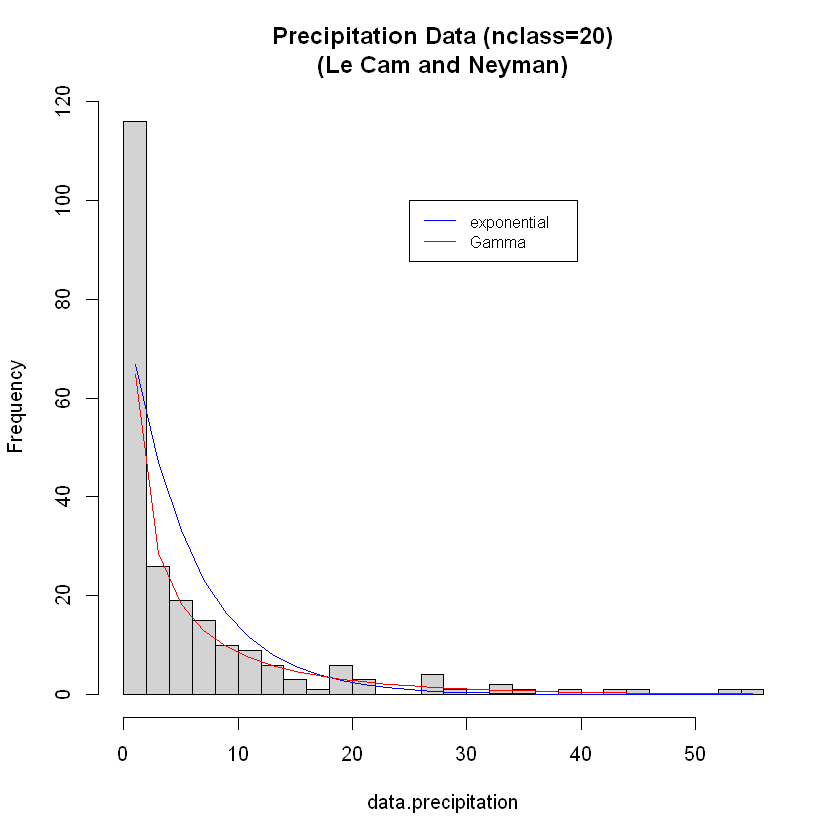

In [9]:
#     Add pdf to histogram
h <- hist(data.precipitation, nclass=20,
     main="Precipitation Data (nclass=20)\n(Le Cam and Neyman)")
x.min <- min(data.precipitation)
x.max <- max(data.precipitation)
dx <- diff(h$mids[1:2])

x.mids <- h$mids
y.mids.exp <- dexp(x.mids, 1/data.precipitation.xbar) * dx * length(data.precipitation)
lines(x.mids, y.mids.exp, col="blue")

y.mids.gamma <- dgamma(x.mids, shape=alphahat.mom, rate=lambdahat.mom) * dx * length(data.precipitation)
lines(x.mids, y.mids.gamma, col="red")

legend(25, 100, legend=c("exponential", "Gamma"), 
       col=c("blue", "red"), lty=c(1,1), cex=0.8)

In [10]:
## Bootstrap using the boot package:
library(boot)

fcn.fitdistr.mom.gamma.forboot <- function(x, ind){
  x.ind <- x[ind]
  x.mean <- mean(x.ind)
  x.var  <- mean(x.ind^2) - (x.mean^2)
  rate.mom <- x.mean/x.var
  shape.mom <- (x.mean^2)/x.var
  result <- c(shape.mom, rate.mom)
  return(result)
}

set.seed(1)
my.boot <- boot(data=data.precipitation, 
                statistic=fcn.fitdistr.mom.gamma.forboot, 
                R=1000)

names(my.boot)  # get the names of an object
print(my.boot)

[1] "t0"        "t"         "R"         "data"      "seed"      "statistic"
 [7] "sim"       "call"      "stype"     "strata"    "weights"


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = data.precipitation, statistic = fcn.fitdistr.mom.gamma.forboot, 
    R = 1000)


Bootstrap Statistics :
      original      bias    std. error
t1* 0.37791546 0.011395679  0.04793342
t2* 0.06630609 0.002449339  0.01020380


In [11]:
## Mannually calculating bootstrap statistics:
my.boot.means <- c(mean(my.boot$t[, 1]), mean(my.boot$t[, 2]))
my.boot.sds <- c(sd(my.boot$t[, 1]), sd(my.boot$t[, 2]))

my.boot.results <- cbind(my.boot.means, my.boot.sds)
rownames(my.boot.results) <- c("shape", "rate")
my.boot.results

my.boot.means my.boot.sds
shape 0.38931114    0.04793342 
rate  0.06875543    0.01020380

In [70]:
## Precipitation xT of return period T (Optional):
## (重现期为 T 的降雨量 xT)
## suppose d is the averaged inter-event time of rains,
## F(x) is the CDF of precipitation.
## d/T = 1 - F(xT) <=> 
## xT = F^{-1} (1 - d/T)

n <- length(data.precipitation)  ## no. of rains in five years
d <- 5 / n    ## averaged inter-event time of rains
T <- 50       ## return period

xT <- qgamma(1- d/T, shape=alphahat.mom, rate=lambdahat.mom)
xT

## Compare to empirical (only meaningful for small T):
# unname( quantile(data.precipitation, 1 - 5/T/n) )

[1] 85.94507

In [71]:
## Using fitdistrplus for fitting:
library(fitdistrplus)
myfit.mom <- fitdist(data.precipitation, "gamma", method="mme")
summary(myfit.mom)

Fitting of the distribution ' gamma ' by matching moments 
Parameters : 
        estimate
shape 0.37791546
rate  0.06630609
Loglikelihood:  -550.8773   AIC:  1105.755   BIC:  1112.604 

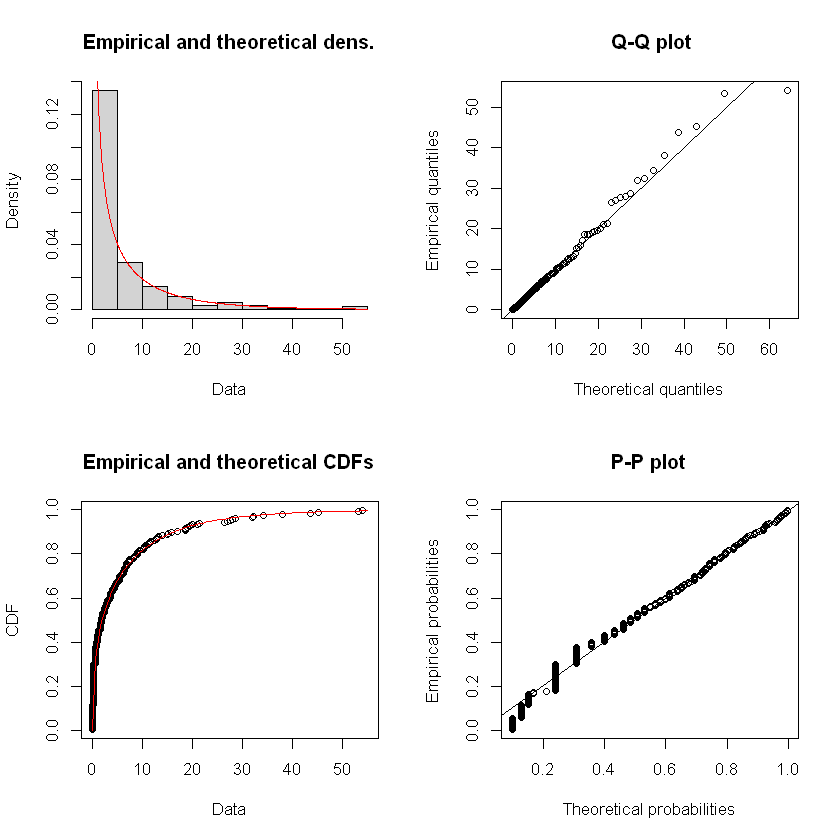

In [41]:
# Graphical diagnostic:
plot(myfit.mom)

In [25]:
## Parametric boostrap of MOM, using fitdistrplus:
myfit.mom.boot <- bootdist(myfit.mom, bootmethod="param", niter=1000)
summary(myfit.mom.boot)

Parametric bootstrap medians and 95% percentile CI 
          Median       2.5%      97.5%
shape 0.39027039 0.26631369 0.51640710
rate  0.06832383 0.04532618 0.09792314

In [27]:
## Extract bootstrapped estimations:
# myfit.mom.boot$estim

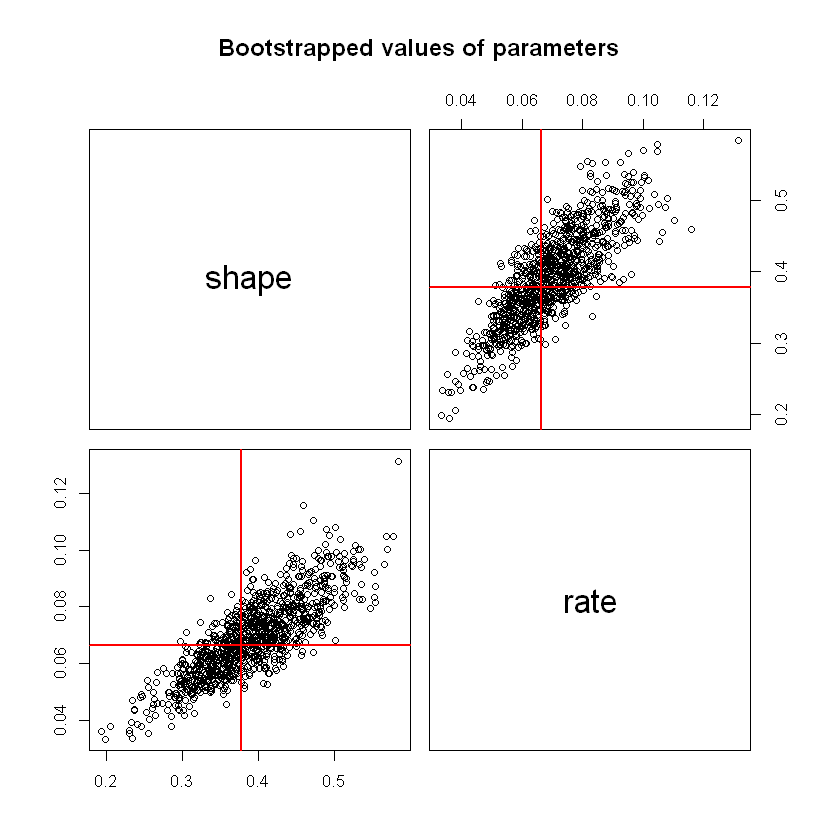

In [29]:
## Plot bootstrap results:
plot(myfit.mom.boot, trueval=myfit.mom$estimate)

In [73]:
## Some goodness-of-fit (GOF) statistics,
## and chi-squared GOF test:
gofstat(myfit.mom, discrete=TRUE)

Chi-squared statistic:  19.09159 
Degree of freedom of the Chi-squared distribution:  9 
Chi-squared p-value:  0.02442528 
Chi-squared table:
          obscounts theocounts
<= 0.0508  26.00000   29.67882
<= 0.254   42.00000   24.64600
<= 0.508   18.00000   15.94544
<= 1.27    17.00000   27.73479
<= 2.032   18.00000   17.49135
<= 3.302   15.00000   20.25713
<= 4.572   15.00000   14.52678
<= 6.35    16.00000   15.01146
<= 8.89    17.00000   15.13241
<= 12.95   15.00000   15.63133
<= 21.34   15.00000   16.49841
> 21.34    13.00000   14.44608

Goodness-of-fit criteria
                               1-mme-gamma
Akaike's Information Criterion    1105.755
Bayesian Information Criterion    1112.604

summary statistics
------
min:  0.0254   max:  54.102 
median:  1.778 
mean:  5.699559 
estimated sd:  9.291859 
estimated skewness:  2.778925 
estimated kurtosis:  11.87935 

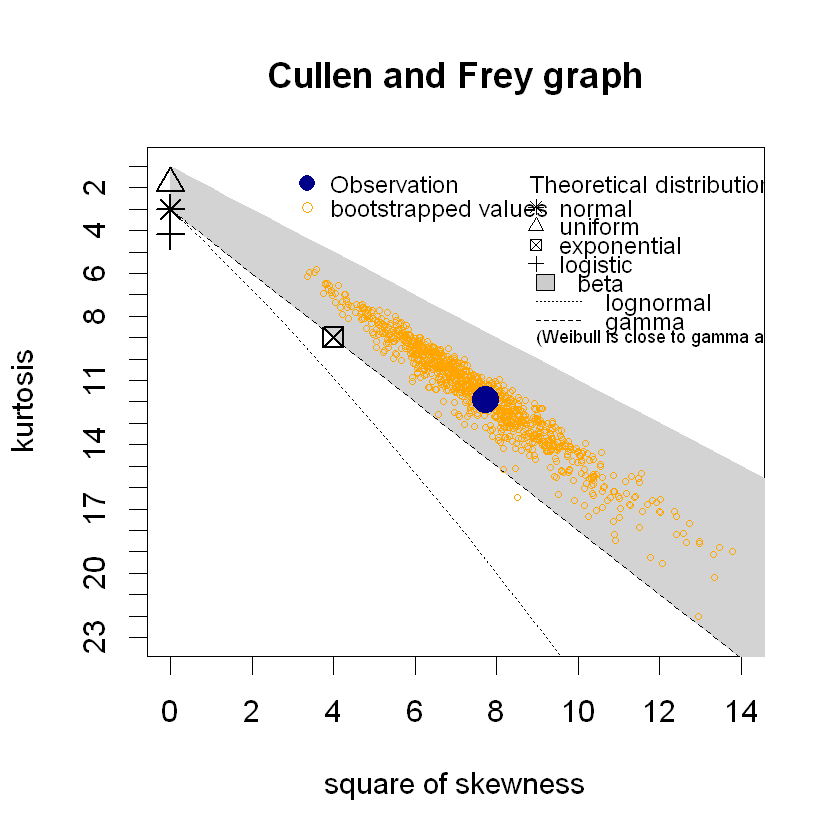

In [74]:
## skewness and kurtosis with bootstrap:
par(cex=1.5)
descdist(data.precipitation, boot=1000)

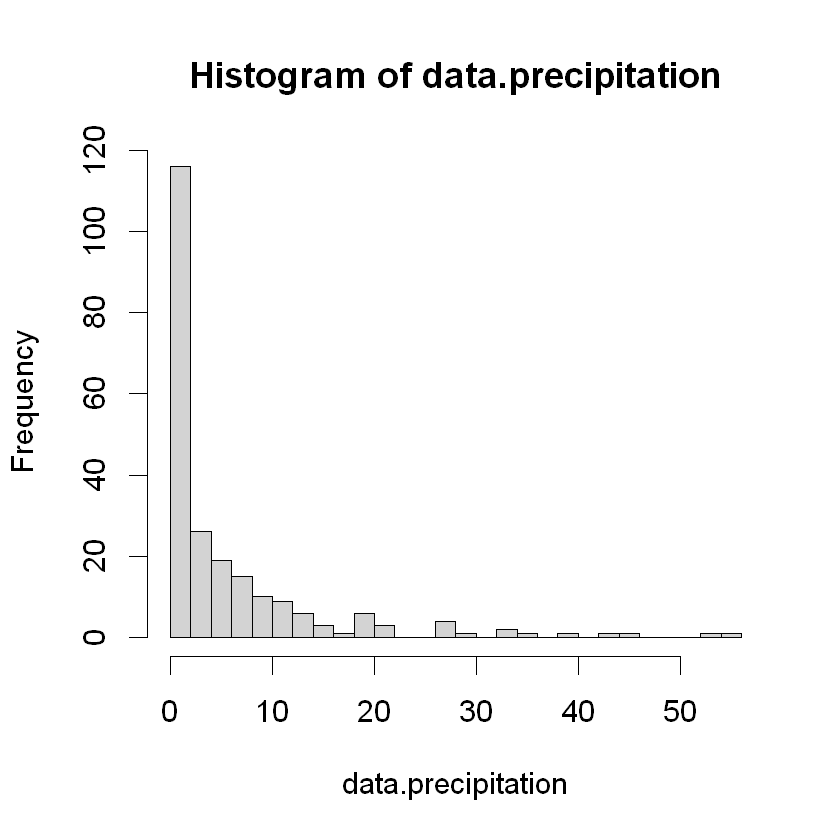

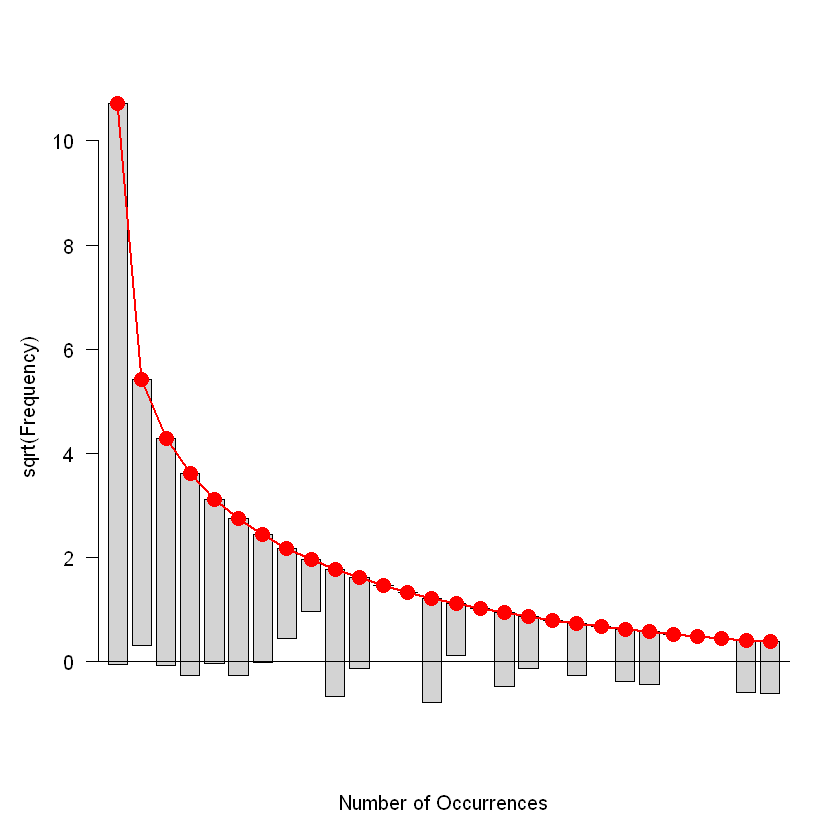

In [56]:
## Rootogram to show goodness-of-fit：
library(vcd)

par(cex=1.5)
h <- hist(data.precipitation, nclass=20)
dx <- diff(h$mids[1:2])
x.grid <- h$breaks
y.grid <- pgamma(x.grid, shape=alphahat.mom, rate=lambdahat.mom)
y.mids <- y.grid[-1] - y.grid[-length(y.grid)]
y.mids <- y.mids * length(data.precipitation)

# rootogram(h$counts, y.mids, scale="raw", type="standing")
rootogram(h$counts, y.mids, type="hanging")
# rootogram(h$counts, y.mids, type="deviation")

In [69]:
## Comparison to MLE:
myfit.mle <- fitdist(data.precipitation, "gamma", method="mle")
summary(myfit.mle)
# plot(myfit.mle)

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
shape 0.44074172 0.033756002
rate  0.07733583 0.009737695
Loglikelihood:  -548.9403   AIC:  1101.881   BIC:  1108.731 
Correlation matrix:
          shape      rate
shape 1.0000000 0.6080935
rate  0.6080935 1.0000000


In [68]:
## Boostrap of MLE:
myfit.mle.boot <- bootdist(myfit.mle, niter=1000)
summary(myfit.mle.boot)
# plot(myfit.mle.boot, trueval=myfit.mle$estimate)

Parametric bootstrap medians and 95% percentile CI 
         Median       2.5%     97.5%
shape 0.4425860 0.38020819 0.5201954
rate  0.0784493 0.06108783 0.1024366

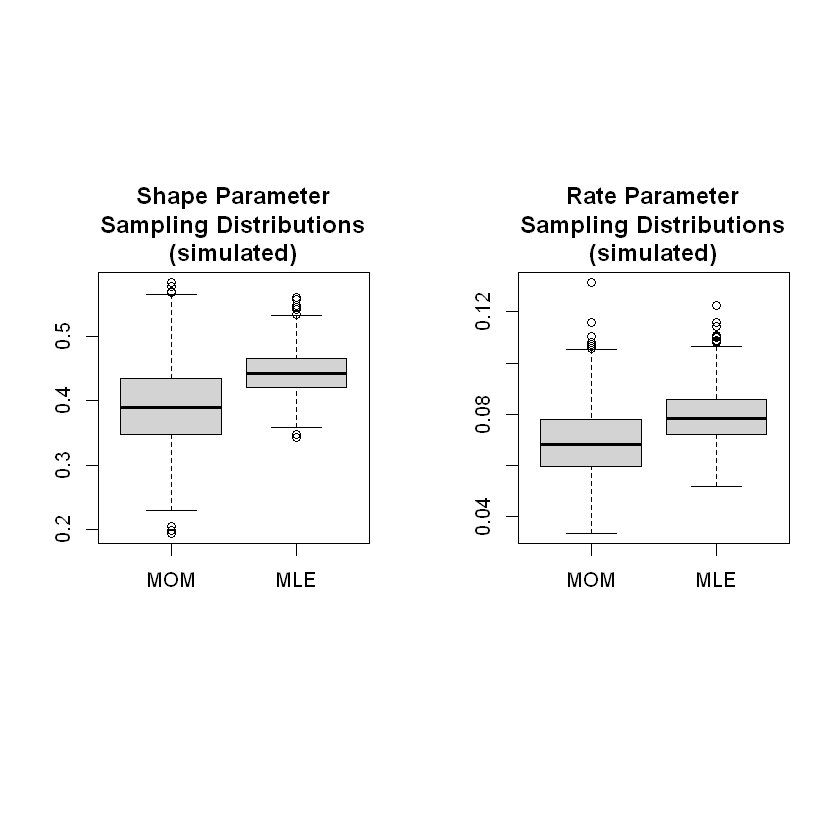

In [75]:
#   Boxplot comparisons of MOM and MLE"
par(mfcol=c(1,2), cex=1, pty="s")
boxplot(cbind(MOM = myfit.mom.boot$estim["shape"],
              MLE = myfit.mle.boot$estim["shape"]),
        names = c("MOM", "MLE"),
        main="Shape Parameter\nSampling Distributions\n(simulated)")

boxplot(cbind(MOM = myfit.mom.boot$estim["rate"],
              MLE = myfit.mle.boot$estim["rate"]),
        names = c("MOM", "MLE"),
        main="Rate Parameter\nSampling Distributions\n(simulated)")